In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive
%cd My Drive
%cd waste_classification
%ls

/content/drive
/content/drive/My Drive
/content/drive/My Drive/waste_classification
capture_image/      detect_video.py       ser.py           Untitled.ipynb
checkpoints/        docs/                 setup.py         video_capture.py
conda-gpu.yml       logs/                 test_2.py        visualize_dataset.py
convert.py          output.png            test.py          weight/
custom_train.ipynb  __pycache__/          tf_record.py     xml_to_csv.py
data/               realsense.py          tools/           yolov3_tf2/
dataset/            requirements-gpu.txt  train.py         yolov3_tf2.egg-info/
detect.py           serial/               Untitled1.ipynb


In [ ]:
#!git clone https://github.com/zzh8829/yolov3-tf2
!pip install -r requirements-gpu.txt

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

In [4]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12568136943270879017, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14557987259988032263
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2191076889032867279
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13310126441736021256
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
FLAGS.image = 'data/girl.png'
FLAGS.weights= 'weight/yolov3-tiny.tf'
FLAGS.tiny=True
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))




In [ ]:
#--mode fit --transfer darknet \
#--mode fit --transfer fine_tune \
#--weights_num_classes 2 

In [ ]:
!python train.py \
	--dataset ./dataset/train_last.record \
	--val_dataset ./dataset/test_last.record \
	--classes ./data/custom_1.names \
	--num_classes 2 \
	--mode fit \
	--transfer fine_tune \
	--batch_size 15 \
	--epochs 50 \
	--weights ./checkpoints/waste_classification_40.tf \
	--learning_rate 1e-6

In [ ]:
!python train.py \
	--dataset ./dataset/train_last.record \
	--val_dataset ./dataset/test_last.record \
	--classes ./data/custom_1.names \
	--num_classes 2 \
	--mode fit \
	--transfer darknet \
	--batch_size 15 \
	--epochs 100 \
	--weights ./checkpoints/waste_classification_2_30.tf \
	--learning_rate 1e-3

2020-09-24 06:25:51.669040: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-24 06:25:53.106380: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-24 06:25:53.112732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-24 06:25:53.113370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-09-24 06:25:53.113408: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-24 06:25:53.115164: I tensorflow/stream_executor/platform/default

In [ ]:
!python train.py \
	--dataset ./dataset/multi_train02.record \
	--val_dataset ./dataset/multi_test02.record \
	--classes ./data/custom_1.names \
	--num_classes 2 \
	--mode fit \
	--transfer fine_tune \
	--batch_size 15 \
	--epochs 50 \
	--weights ./checkpoints/tiny_6_11.tf \
	--learning_rate 1e-6 \
	--outname ds\
	--weights_num_classes 2 \
  	--tiny True

I0831 08:59:21.678789 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.18703341484069824
I0831 08:59:21.679697 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.9857 [0.26849264 0.6796191  0.611265   1.        ]
can 0.8328 [0.08098532 0.2048619  0.40770763 0.6236567 ]
PET 0.5874 [0.6524985 0.1464526 0.8840833 0.8007802]
can 0.2881 [0.35706663 0.02671748 0.5633472  0.49364161]


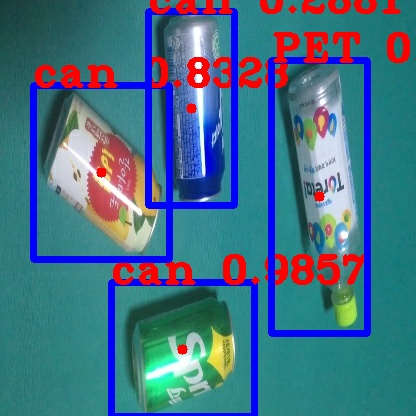

I0831 08:59:22.189972 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.18426012992858887
I0831 08:59:22.190838 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.8795 [0.14346382 0.3165316  0.6342777  0.7862058 ]


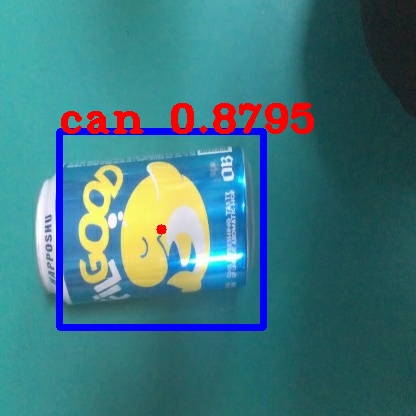

I0831 08:59:22.558444 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.18827056884765625
I0831 08:59:22.559354 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


PET 0.9579 [0.1423443  0.05114135 0.5557012  0.9545964 ]
can 0.8989 [0.51570004 0.32041246 0.8769894  0.6277117 ]


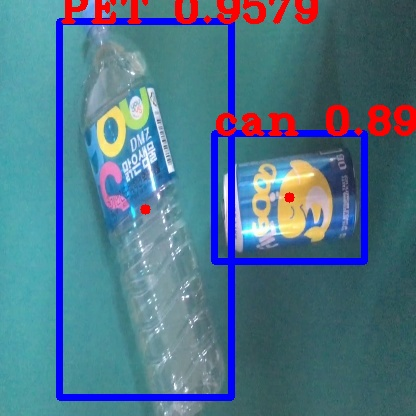

I0831 08:59:22.935438 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.1817476749420166
I0831 08:59:22.936321 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.9080 [0.5677631  0.61663234 0.9251207  0.9347527 ]
PET 0.8813 [0.0169744  0.40871614 0.47205657 0.9658615 ]
can 0.3643 [0.42200428 0.03149047 0.6568832  0.6692654 ]


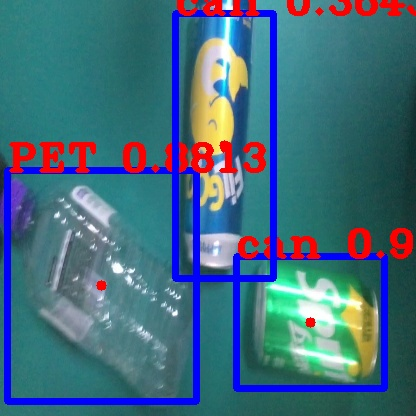

I0831 08:59:23.363642 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.1915426254272461
I0831 08:59:23.364528 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.9181 [0.08451654 0.         0.41055244 0.43924275]
PET 0.6197 [0.7068578  0.1610282  0.99002564 0.9178967 ]
can 0.2552 [0.4677592 0.        0.66874   0.702029 ]


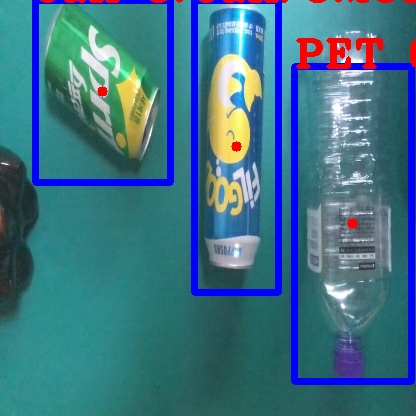

I0831 08:59:23.912873 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.1827085018157959
I0831 08:59:23.913925 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


PET 0.9172 [0.26568526 0.13436326 0.70321006 0.9532268 ]
can 0.8290 [0.19861905 0.4853249  0.42265838 0.9202002 ]
can 0.6383 [0.57983685 0.11757812 0.82868457 0.6524137 ]


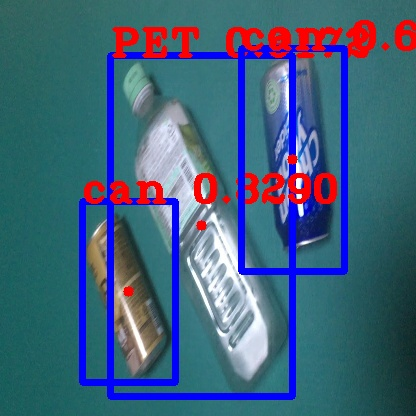

I0831 08:59:24.260357 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.1898365020751953
I0831 08:59:24.261269 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.9869 [0.41468403 0.63968205 0.7926953  0.9587326 ]
can 0.7885 [0.67735416 0.19257501 0.9127657  0.7335298 ]
can 0.7586 [0.421464   0.14675948 0.71283066 0.6230036 ]


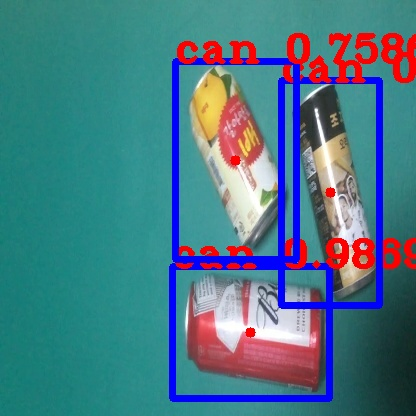

I0831 08:59:24.857986 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.1912691593170166
I0831 08:59:24.859295 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


PET 0.9119 [0.06152086 0.20207036 0.40845448 0.88628185]
can 0.8607 [0.41832906 0.571575   0.76068753 0.9189704 ]
can 0.5372 [0.6660341  0.10396305 0.907971   0.68482316]
can 0.4079 [0.39848965 0.08026101 0.68706304 0.57423687]


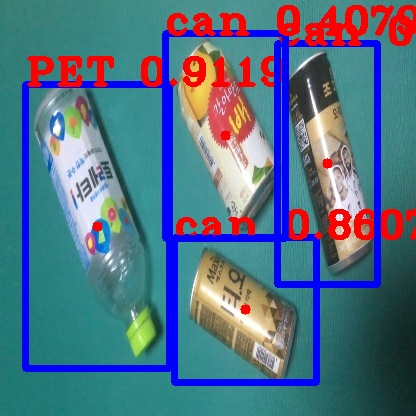

I0831 08:59:25.497660 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.19402790069580078
I0831 08:59:25.498628 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.4158 [0.34793475 0.25936753 0.6292378  0.82560927]


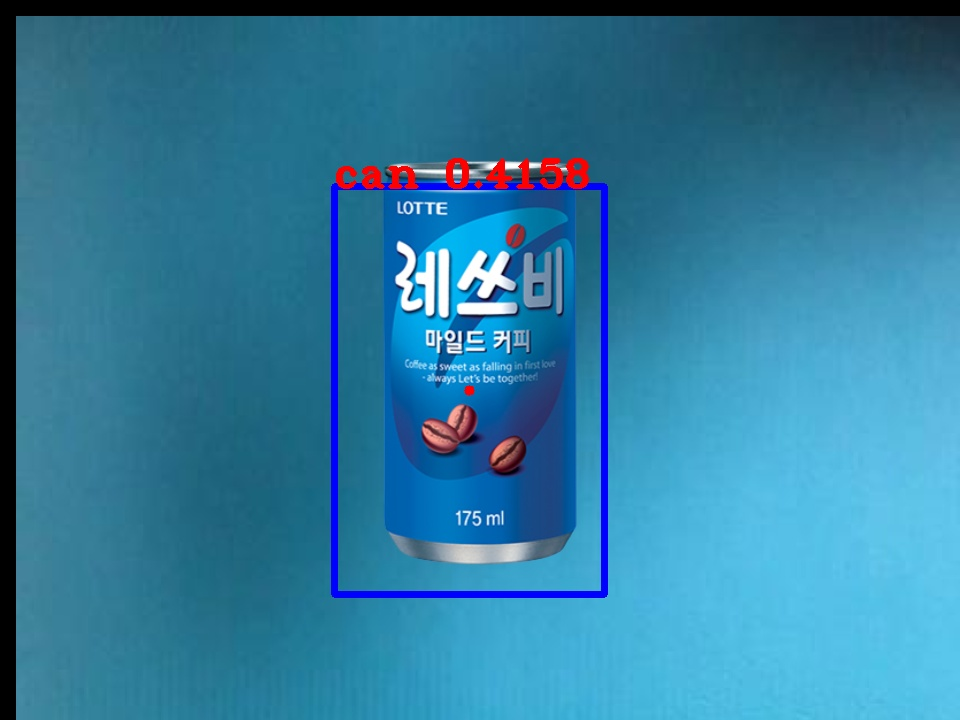

I0831 08:59:25.962667 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.18910694122314453
I0831 08:59:25.964206 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.6918 [0.14715812 0.07588914 0.3956878  0.49477312]
can 0.4992 [0.77073073 0.51964486 0.98371005 0.78674996]
PET 0.3281 [0.51542264 0.33439687 0.7765129  0.9725261 ]
PET 0.1808 [0.3077231  0.09822674 0.617513   0.5765664 ]


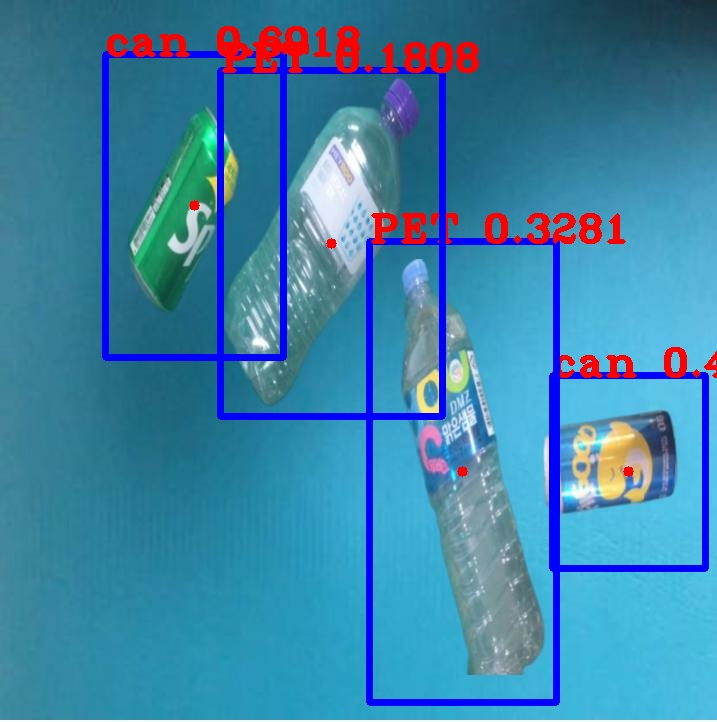

I0831 08:59:26.419907 140374487357312 <ipython-input-4-7bb4fed08f82>:46] time: 0.19257402420043945
I0831 08:59:26.420799 140374487357312 <ipython-input-4-7bb4fed08f82>:48] detections:


can 0.8466 [0.60760236 0.42953646 0.831305   0.9844041 ]
can 0.8106 [0.38043174 0.02838349 0.62358785 0.5916585 ]


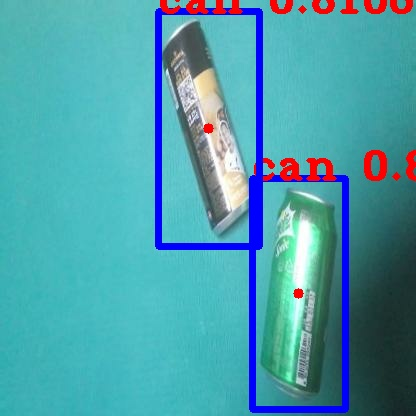

In [ ]:
from yolov3_tf2.utils import draw_outputs

FLAGS.num_classes = 2
FLAGS.classes = 'data/custom_2.txt'
#FLAGS.weights = 'weight/multi_07.tf'
FLAGS.weights = 'checkpoints/multi_16_55.tf'
#FLAGS.weights = 'weight/multi_9_5.tf'
#FLAGS.image = 'data/test_image/model_test10.png'
#FLAGS.image = 'data/test_image/can_test01.jpg'
#FLAGS.image = 'data/test_image/pet_test01.jpg'
#FLAGS.image='data/test01.jpg'
FLAGS.image='data/test_image/frame'
FLAGS.tiny=False

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.5
FLAGS.yolo_score_threshold = 0.1

image_list = []

for i in range(1,20):
  image_list.append(FLAGS.image+'_{}.jpg'.format(i))

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

for i in image_list:

  img_raw = tf.image.decode_image(
      open(i, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      print("{} {:.4f} {}".format(class_names[int(classes[0][i])],
                              np.array(scores[0][i]),
                               np.array(boxes[0][i])))
#     logging.info('\n{}, {}, {}'.format(class_names[int(classes[0][i])],
#                                          np.array(scores[0][i]),
#                                          np.array(boxes[0][i])))
                                        

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img,location = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  
  #img = cv2.resize(img,(416,416))
  #cv2.imwrite('output.png',img)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1])))



I0901 05:03:20.943516 140238583465856 <ipython-input-8-6b9ddfaaf15f>:30] weights loaded
I0901 05:03:20.947637 140238583465856 <ipython-input-8-6b9ddfaaf15f>:33] classes loaded
I0901 05:03:21.072588 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11659097671508789
I0901 05:03:21.073424 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.9648 [0.11682895 0.06458217 0.700734   0.6181684 ]
can 0.6624 [0.7250018  0.20862243 0.96860147 0.8909813 ]


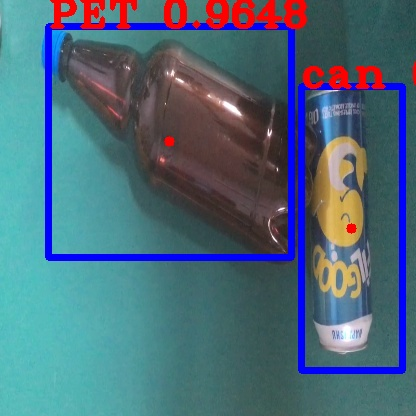

I0901 05:03:21.213638 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10940217971801758
I0901 05:03:21.215112 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.9594 [0.44353303 0.04998143 0.9936973  0.4278599 ]
can 0.8532 [0.53924793 0.49444127 0.8605493  0.8340008 ]
can 0.7234 [0.05346873 0.34972274 0.48121712 0.84108794]


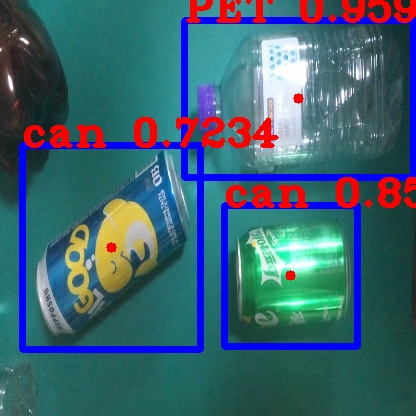

I0901 05:03:21.358499 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.1081242561340332
I0901 05:03:21.359361 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.8233 [0.39045194 0.06791228 0.67588675 0.8000688 ]
can 0.6133 [0.15811509 0.17171413 0.4353413  0.7491394 ]
PET 0.3955 [0.7290414  0.04466572 0.9655667  0.91438866]


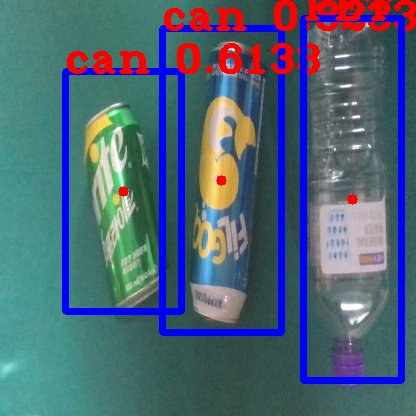

I0901 05:03:21.503244 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10906219482421875
I0901 05:03:21.504047 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9852 [0.2693374  0.6723639  0.6089039  0.99907947]
can 0.6938 [0.0879426  0.20190327 0.42068714 0.6119373 ]
can 0.5214 [0.35377464 0.02009909 0.5645343  0.49636537]
PET 0.4790 [0.647207   0.14050952 0.88947046 0.79582083]


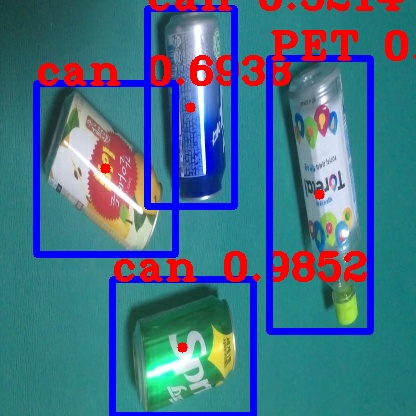

I0901 05:03:21.652210 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11521100997924805
I0901 05:03:21.652988 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9475 [0.4183741  0.63881975 0.79359293 0.9592739 ]
can 0.7935 [0.6822156  0.19210163 0.9160471  0.7360387 ]
can 0.6886 [0.42266494 0.1464968  0.7181706  0.6237972 ]


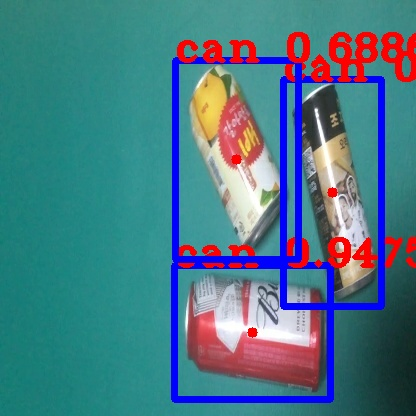

I0901 05:03:21.794924 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10614228248596191
I0901 05:03:21.795676 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.8238 [0.5671422 0.        0.9832421 0.975212 ]
can 0.4234 [0.2722926  0.26457578 0.641855   0.8022292 ]


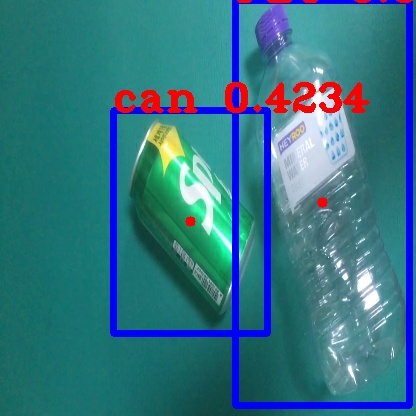

I0901 05:03:21.953848 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.12661361694335938
I0901 05:03:21.954588 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.9746 [0.4329211  0.04997517 0.99706084 0.42351806]
can 0.7535 [0.5340177  0.49455792 0.8673408  0.8343398 ]
can 0.5997 [0.06519148 0.33354515 0.47959283 0.82520825]


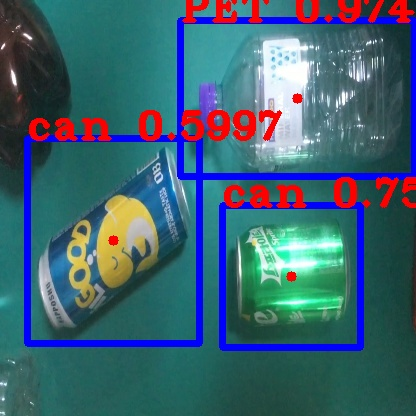

I0901 05:03:22.094844 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10591483116149902
I0901 05:03:22.097681 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.8921 [0.28968635 0.6341851  0.6973429  0.9165344 ]
PET 0.8257 [0.04615855 0.06127369 0.6729339  0.6006068 ]
PET 0.5457 [0.7139327  0.18503627 0.972992   0.8980335 ]


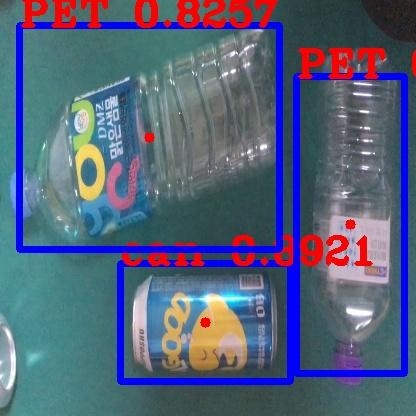

I0901 05:03:22.240938 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10744166374206543
I0901 05:03:22.241791 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9749 [0.26609313 0.6786562  0.61495346 1.        ]
can 0.7486 [0.08261093 0.20694828 0.4048092  0.61979574]
can 0.5008 [0.3537724  0.02659938 0.5639861  0.49641135]
PET 0.3835 [0.65108544 0.13407463 0.8848857  0.8066376 ]


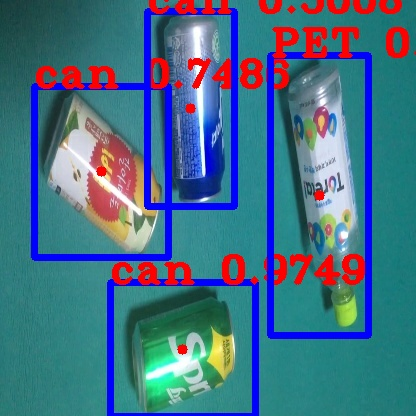

I0901 05:03:22.386142 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10791945457458496
I0901 05:03:22.387217 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.8966 [0.05711892 0.32257703 0.65500534 0.78703904]


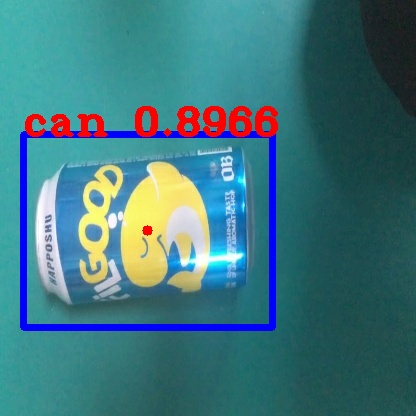

I0901 05:03:22.527884 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11259222030639648
I0901 05:03:22.528759 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.8286 [0.50825787 0.32416296 0.87169933 0.62091565]
PET 0.7861 [0.14653955 0.03685865 0.5599673  0.968058  ]


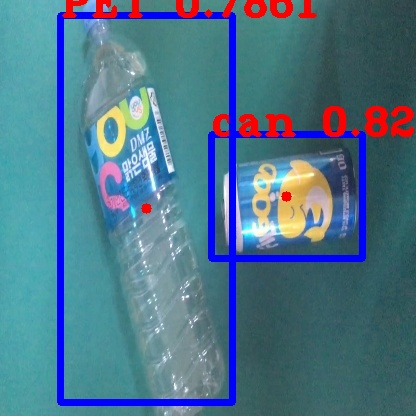

I0901 05:03:22.672589 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11479759216308594
I0901 05:03:22.673454 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.9071 [0.00159408 0.39903662 0.4827088  0.9906323 ]
can 0.7525 [0.5669508  0.6195601  0.92957044 0.9383    ]
can 0.6607 [0.4279757  0.0166854  0.65120775 0.6761123 ]


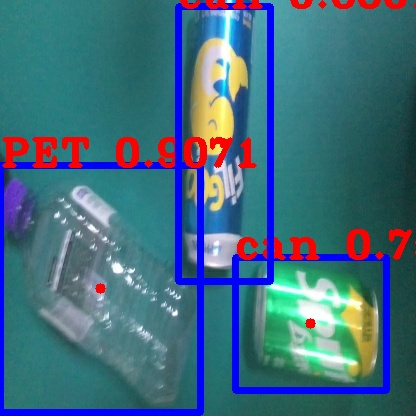

I0901 05:03:22.823349 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11389517784118652
I0901 05:03:22.824544 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9186 [6.9226742e-02 2.7948618e-04 4.2143548e-01 4.3126631e-01]
can 0.6479 [0.45763958 0.00365627 0.66759515 0.69494724]
PET 0.5218 [0.7183492  0.16561809 0.9847404  0.9156207 ]


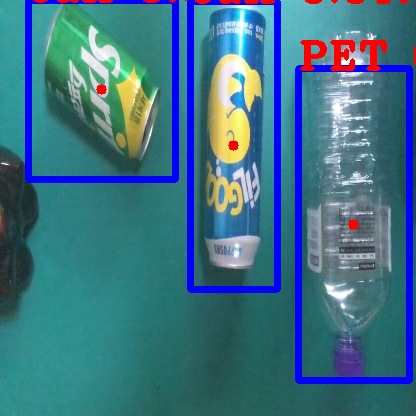

I0901 05:03:22.967804 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11336445808410645
I0901 05:03:22.968536 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.7132 [0.1941409  0.48559922 0.42822653 0.9202202 ]
can 0.7030 [0.60649633 0.10946727 0.8096281  0.6280018 ]
PET 0.5917 [0.27280715 0.12700784 0.7022283  0.96202934]


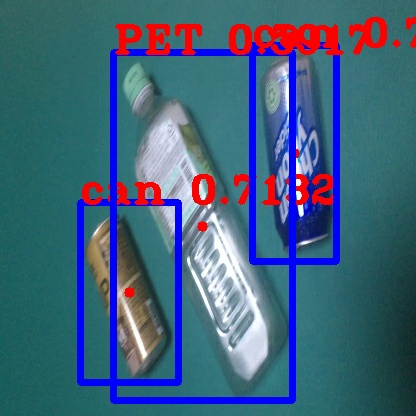

I0901 05:03:23.111070 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10637927055358887
I0901 05:03:23.114014 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9475 [0.4183741  0.63881975 0.79359293 0.9592739 ]
can 0.7935 [0.6822156  0.19210163 0.9160471  0.7360387 ]
can 0.6886 [0.42266494 0.1464968  0.7181706  0.6237972 ]


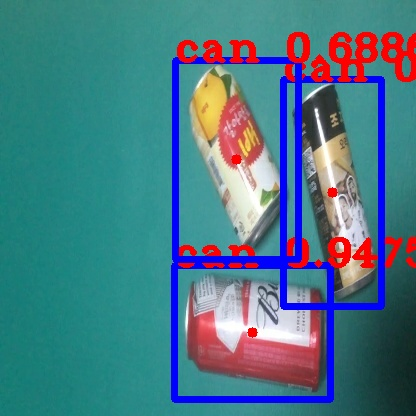

I0901 05:03:23.260439 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11152529716491699
I0901 05:03:23.261727 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.8756 [0.06234774 0.18292513 0.41141272 0.90509415]
can 0.7969 [0.42260394 0.5712293  0.75241697 0.92415994]
can 0.6546 [0.6682322  0.11068323 0.92050517 0.65432763]
can 0.4599 [0.37308824 0.06256267 0.686357   0.54672325]


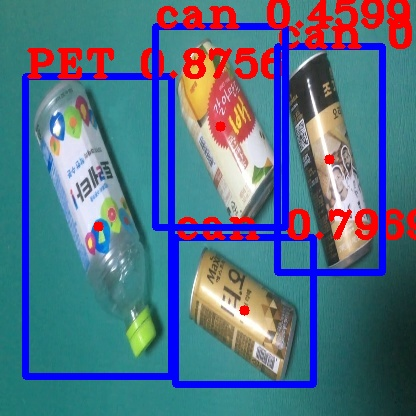

I0901 05:03:23.683851 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11105847358703613
I0901 05:03:23.684900 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.3074 [0.35715413 0.16574189 0.6136737  0.8539629 ]


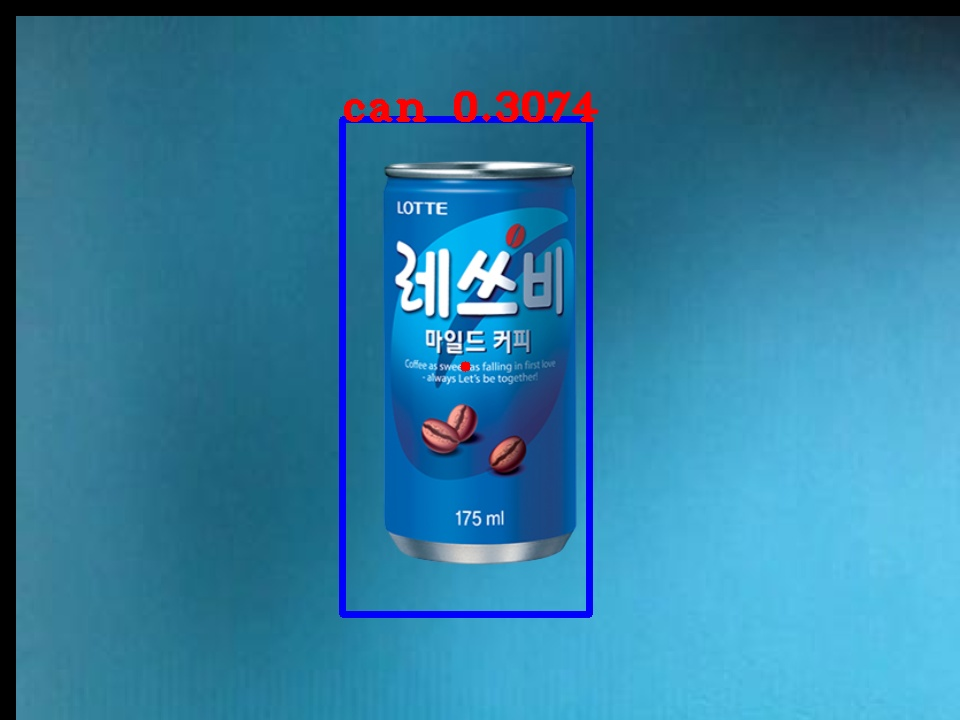

I0901 05:03:24.116310 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11551880836486816
I0901 05:03:24.117263 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.6952 [0.2899822  0.08637562 0.640183   0.58869123]
PET 0.3752 [0.5099993  0.32556495 0.7742717  0.9751637 ]
can 0.2999 [0.1515882  0.06633256 0.3917628  0.4993825 ]


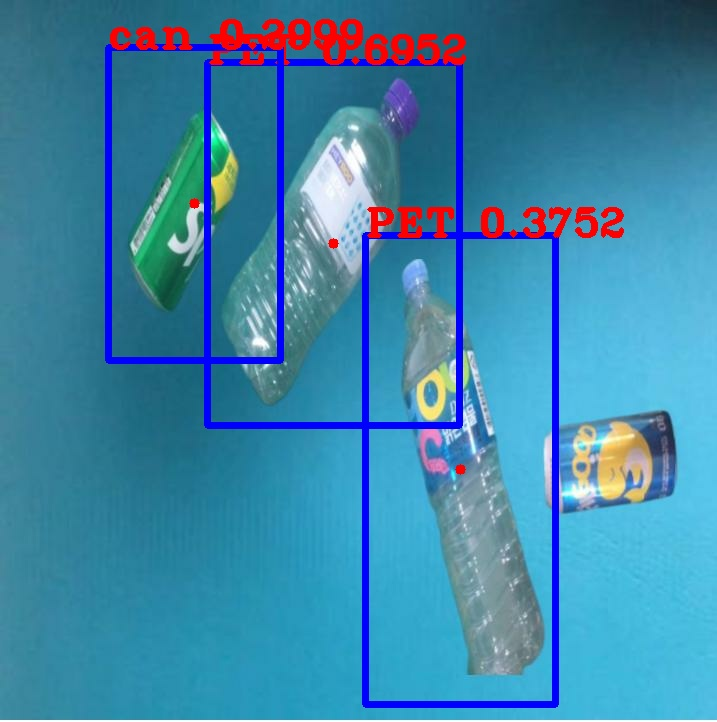

I0901 05:03:24.571699 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.11168837547302246
I0901 05:03:24.572634 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9258 [0.6028616  0.44053066 0.82956845 0.9735166 ]
can 0.8869 [0.37545514 0.0280996  0.62678707 0.595292  ]


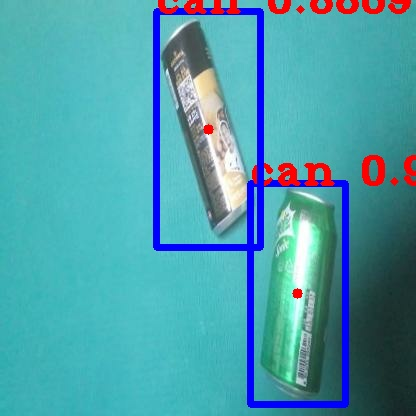

I0901 05:03:24.934318 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.1083221435546875
I0901 05:03:24.935139 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.7261 [0.33024037 0.24996877 0.86821187 0.6429033 ]
can 0.4944 [0.0279869  0.18587458 0.29318786 0.85768247]


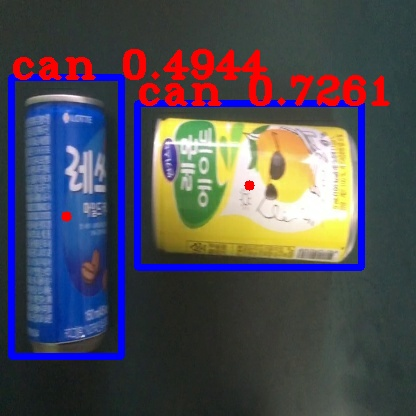

I0901 05:03:25.317946 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10674333572387695
I0901 05:03:25.319243 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.8106 [0.14567746 0.05984977 0.51879126 0.8967991 ]
can 0.7364 [0.58426684 0.16132104 0.81708294 0.8801116 ]


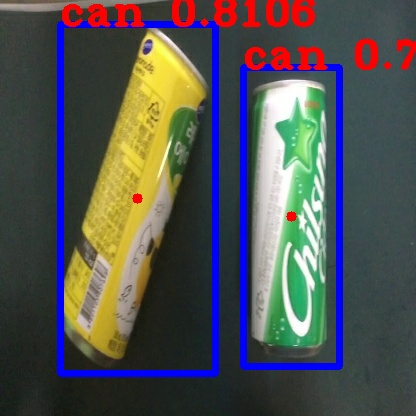

I0901 05:03:25.744166 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.10503911972045898
I0901 05:03:25.745010 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


can 0.9096 [0.2782842  0.12305525 0.66903526 0.8338653 ]


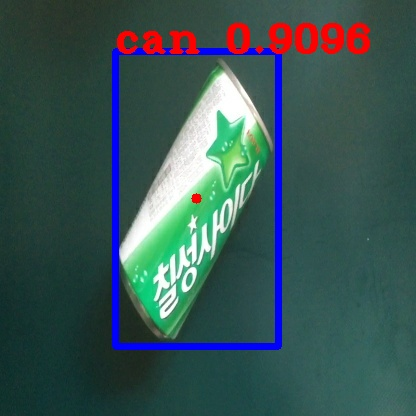

I0901 05:03:26.099138 140238583465856 <ipython-input-8-6b9ddfaaf15f>:46] time: 0.1183481216430664
I0901 05:03:26.100154 140238583465856 <ipython-input-8-6b9ddfaaf15f>:48] detections:


PET 0.6324 [0.23459727 0.16245127 0.865285   0.94495296]


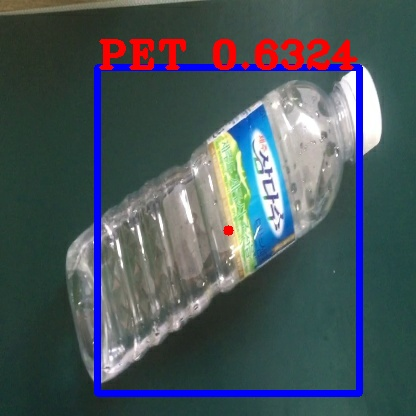

In [ ]:
from yolov3_tf2.utils import draw_outputs

FLAGS.num_classes = 2
FLAGS.classes = 'data/custom_2.txt'
#FLAGS.weights = 'weight/multi_07.tf'
FLAGS.weights = 'checkpoints/multi_17_50.tf'
#FLAGS.weights = 'weight/multi_9_5.tf'
#FLAGS.image = 'data/test_image/model_test10.png'
#FLAGS.image = 'data/test_image/can_test01.jpg'
#FLAGS.image = 'data/test_image/pet_test01.jpg'
#FLAGS.image='data/test01.jpg'
FLAGS.image='data/test_image/frame'
FLAGS.tiny=False

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.5
FLAGS.yolo_score_threshold = 0.1

image_list = []

for i in range(1,24):
  image_list.append(FLAGS.image+'_{}.jpg'.format(i))

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

for i in image_list:

  img_raw = tf.image.decode_image(
      open(i, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      print("{} {:.4f} {}".format(class_names[int(classes[0][i])],
                              np.array(scores[0][i]),
                               np.array(boxes[0][i])))
#     logging.info('\n{}, {}, {}'.format(class_names[int(classes[0][i])],
#                                          np.array(scores[0][i]),
#                                          np.array(boxes[0][i])))
                                        

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img,location = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  
  #img = cv2.resize(img,(416,416))
  #cv2.imwrite('output.png',img)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1])))



I0901 05:17:11.719855 140238583465856 <ipython-input-12-aaa758299395>:30] weights loaded
I0901 05:17:11.725481 140238583465856 <ipython-input-12-aaa758299395>:33] classes loaded
I0901 05:17:11.852745 140238583465856 <ipython-input-12-aaa758299395>:46] time: 0.11580657958984375
I0901 05:17:11.853455 140238583465856 <ipython-input-12-aaa758299395>:48] detections:


can 0.7261 [0.33024037 0.24996877 0.86821187 0.6429033 ]
can 0.4944 [0.0279869  0.18587458 0.29318786 0.85768247]


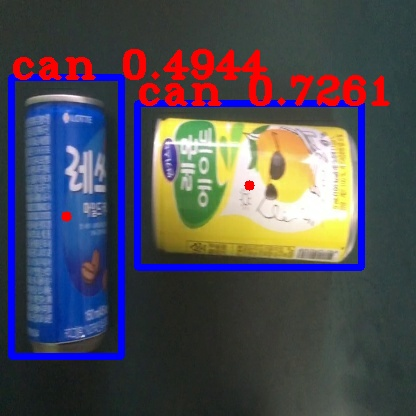

In [ ]:
from yolov3_tf2.utils import draw_outputs

FLAGS.num_classes = 2
FLAGS.classes = 'data/custom_2.txt'
#FLAGS.weights = 'weight/multi_07.tf'
FLAGS.weights = 'checkpoints/multi_17_50.tf'
#FLAGS.weights = 'weight/multi_9_5.tf'
#FLAGS.image = 'data/test_image/model_test10.png'
#FLAGS.image = 'data/test_image/can_test01.jpg'
#FLAGS.image = 'data/test_image/pet_test01.jpg'
#FLAGS.image='data/test01.jpg'
FLAGS.image='data/test_image/frame_20'
FLAGS.tiny=False

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.5
FLAGS.yolo_score_threshold = 0.1

image_list = []


image_list.append(FLAGS.image+'.jpg')

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

for i in image_list:

  img_raw = tf.image.decode_image(
      open(i, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      print("{} {:.4f} {}".format(class_names[int(classes[0][i])],
                              np.array(scores[0][i]),
                               np.array(boxes[0][i])))
#     logging.info('\n{}, {}, {}'.format(class_names[int(classes[0][i])],
#                                          np.array(scores[0][i]),
#                                          np.array(boxes[0][i])))
                                        

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img,location = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  
  #img = cv2.resize(img,(416,416))
  cv2.imwrite('output.png',img)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1])))



In [ ]:
!python visualize_dataset.py --dataset= multi_train03.record --classes= custom_1.names